## Demo for linear regresssion   - Richard Sear 2018

looks at estimating the uncertainties on the best-fit intercept and slope, using 1) jackknife, 2) bootstrap, 3) standard expressions for the uncertainties in the best-fit values.

Note that the maths behind estimating errors is pretty specialist and hairy stuff. This Jupyter Python notebook ignores this maths in favour of a being a cookbook with recipes for calculating estimates. Note that error ESTIMATES are just that, estimates, and so not guaranteed to be correct, in particular as the stats literature on these methods notes, all methods of obtaining error estimates make assumptions - if these assumptions are wrong so will be the error estimates. Notably the standard expressions given in stats textbooks (3 here) typically assume that the errors have a Gaussian distribution, which is often close to being true, but is not true in general.

The bootstrap method does not make this assumption, is a bit more flexible, and can be more accurate, than the jackknife method, and so is the one I would typically recommend. This [article](https://statistics.stanford.edu/sites/default/files/BIO%2083.pdf), although old, describes the idea of the bootstrap method very well, in a not-maths-heavy way. Note that the boostrap method can be used to give error estimates in anything where you are taking noisy data, and this article discusses the bootstrap method in estimating the error not in a fit but in estimating what they call the correlation coefficient.

Note that both the jackkife and bootstrap employ what is called resampling. Simply speaking the point of resampling is as follows. Ideally, we would like a huge number of data points, as then we could estimate the errors very accurately. More typically we only have a very limited number of points. We then use resampling that essentially recycles this small number of data points, by using them to approximately mimic the case where we had many more points.

In [1]:
# this makes the plots appear in this notebook
%matplotlib inline

######## We need to import modules into Python
# numpy is basic number crunching
import numpy as np
# need a generator for random integers
from random import randint,gauss,seed
# matplolib is plotting module
import matplotlib.pyplot as plt
###################

This generates some trial data, with deliberately added noise. This is to help understand the principles of linear regression. In practice, you will typically read your data in from a file.

I use 'seed' so data generated is the same each time it runs.

In [2]:
# this starts random number generator at same point each time
seed(981181)
# now generate data that is in fact a straight line plus noise
n_pts=10
print('data has ',n_pts,' points')
x=np.linspace(0.5,25,n_pts)
y=np.zeros(n_pts)
# actual intercept
real_intercept=1.3
real_slope=2.2
print('true intercept ',format(real_intercept,"5.2f"))
print('true slope     ',format(real_slope,"5.2f"))
# gauss introduces Gaussian distributed noise of std deviation epsilon_noise
epsilon_noise=2.0
for i in range(0,n_pts):
    y[i]=real_intercept+real_slope*x[i]+gauss(0.0,epsilon_noise)

data has  10  points
true intercept   1.30
true slope       2.20


Note that when we are fitting data we never know what the true function - if we did there would be no point in fitting as we already know the answer! But here I want to work with data where I know what the answer is, so I can test the approaches used in this notebook.

Now define function to fit straight line $y = m*x + c$ to data - arrays x and y

In [3]:
def linear_fit_calc(xf,yf):
    n_ptsf=len(xf)
# mean values
    mean_xf=np.average(xf)
    mean_yf=np.average(yf)
# first calculate arrays of x minus its mean value
    delta_xf=xf-mean_xf
    delta_yf=yf-mean_yf
# now for best-fit slope m
    m=np.sum(delta_xf*delta_yf)/np.sum(delta_xf**2)
# and best-fit intercept
    c=mean_yf-m*mean_xf
    return m,c

In [4]:
# a straight line of form y = intercept + slope*x is polynomial of order 1
# can change 1 to 2 to fit quadratic polynomial
#slope, intercept =np.polyfit(x,y,1)
slope,intercept=linear_fit_calc(x,y)
print('best fit value of intercept ','%6.3f'%(intercept),' from least squares fitting')
print('best fit value of slope ','%6.3f'%(slope))
#
print('compare to known true intercept ',format(real_intercept,"5.2f"))
print('compare to known true slope     ',format(real_slope,"5.2f"))

best fit value of intercept   2.624  from least squares fitting
best fit value of slope   2.126
compare to known true intercept   1.30
compare to known true slope       2.20


Cell below defines functions for jackknife error estimate. Jackknife deletes each of the 10 points in turn, and fits to the remaining 9 points to obtain 10 estimates of the intercept and the slope. See https://en.wikipedia.org/wiki/Jackknife_resampling#Estimation for how jackknife estimates are calculated. The 


In [5]:
"""
Jackknife error estimates for intercept and slope
for linear regression
RPS June 2018
"""
def jackknife_calc():
# there will be n_pts fits to all possible sets of (n_pts-1) data points
    slope_jack=np.zeros(n_pts)
    intercept_jack=np.zeros(n_pts)
    for i in range(0,n_pts):
# first select each set of (n_pts-1) taken from our data
# which is a set if n_pts, by droping 1 of these points
        x_jack=np.zeros(n_pts-1)
        y_jack=np.zeros(n_pts-1)
        j_jack=0
        for j in range(0,n_pts):
            if(i !=j):
                x_jack[j_jack]=x[j]
                y_jack[j_jack]=y[j]
                j_jack=j_jack+1
# now fit to this set of (n_pts-1) points
        slope_jack[i],intercept_jack[i]=linear_fit_calc(x_jack,y_jack)#np.polyfit(x_jack,y_jack,1)
# now find smallest and largest values of n_pts fits
    ave=np.average(intercept_jack)
    ave_sq=np.average(intercept_jack**2)
    jack_sigma_intercept=np.sqrt(ave_sq-ave**2)
    ave=np.average(slope_jack)
    ave_sq=np.average(slope_jack**2)
    jack_sigma_slope=np.sqrt(ave_sq-ave**2)
    return jack_sigma_intercept,jack_sigma_slope

having defined jackknife function, now use it to obtain estimate of error

In [6]:
# jackknife
print('')
print('now calculate Jackknife uncertainties on intercept & slope')
print('uncertainties are 2*standard deviation from jackknife')
jack_sigma_intercept,jack_sigma_slope=jackknife_calc()
print('best fit value of intercept    ',format(intercept,"5.2f"),'+/-',format(2.0*jack_sigma_intercept,"4.2f"))
print('best fit value of slope    ',format(slope,"5.2f"),'+/-',format(2.0*jack_sigma_slope,"4.2f"))
#
print('compare to known true intercept ',format(real_intercept,"5.2f"))
print('compare to known true slope     ',format(real_slope,"5.2f"))


now calculate Jackknife uncertainties on intercept & slope
uncertainties are 2*standard deviation from jackknife
best fit value of intercept      2.62 +/- 0.66
best fit value of slope      2.13 +/- 0.04
compare to known true intercept   1.30
compare to known true slope       2.20


So, if instead of having n_pts  we had only had 1 less of them, then we'd expect intercepts and slopes in the ranges shown above - these ranges should therefore be reasonable estimates of errors. But note that for this rather noisy data, the jackknife underestimates the errors. As we generated the data from a known function (just for this example, note that usually we don't know the true values!) we can check the error bars, and here they are a little small.

Now do boostrap error analysis, first define a function to do this. Wikipedia page for bootstrap is https://en.wikipedia.org/wiki/Bootstrapping_(statistics).

In [7]:
def bootstrap_calc(prob_conf_interval):
# here I have set the number of times the resampled to 1000, this kind of overkill - making it 100 does not change the
# error estimates much - but as the program runs so quickly it would not run noticeably faster if n_bootstrap
# is reduced so might as well make n_bootstrap large
    n_bootstrap=1000
    slope_boot=np.zeros(n_bootstrap)
    intercept_boot=np.zeros(n_bootstrap)
    for i in range(0,n_bootstrap):
        x_boot=np.zeros(n_pts)
        y_boot=np.zeros(n_pts)
        for j in range(0,n_pts):
            i_sample=randint(0,n_pts-1)
            x_boot[j]=x[i_sample]
            y_boot[j]=y[i_sample]
        slope_boot[i],intercept_boot[i]=linear_fit_calc(x_boot,y_boot)#np.polyfit(x_boot,y_boot,1)
# sort so later we pick out values near bottom and top
    intercept_boot=np.sort(intercept_boot)
    slope_boot=np.sort(slope_boot)
# now n_bootstrap values are sorted from smallest to largest
    f_lower=(1.0-prob_conf_interval)/2.0
    f_upper=1.0-f_lower
    print('lower and upper limits to confidence interval ',format(f_lower,"4.2f"),'&',format(f_upper,"4.2f"))
# 95% level confidence - 95% is just a reasonable but basically arbitrary choice
    n_boot_lower_conf=int(float(n_bootstrap)*f_lower)
    n_boot_upper_conf=int(float(n_bootstrap)*f_upper)
    min_intercept_boot=intercept_boot[n_boot_lower_conf]
    max_intercept_boot=intercept_boot[n_boot_upper_conf]
    min_slope_boot=slope_boot[n_boot_lower_conf]
    max_slope_boot=slope_boot[n_boot_upper_conf]
    return min_intercept_boot,max_intercept_boot,min_slope_boot,max_slope_boot
#########################

Now call this function to get the results

In [8]:
# Bootstrap estimates for statistical error bounds
# making this closer to 1 makes interval larger - more conservative error estimates
prob_conf_interval=0.9
print('estimate that',format(prob_conf_interval*100.0,"4.1f"),'% of the bootstrap sampled values fall with the confidence interval')
min_intercept_boot,max_intercept_boot,min_slope_boot,max_slope_boot=bootstrap_calc(prob_conf_interval)
print('')
print('after boootstrap error analysis the data constrains the fit parameters to ranges:')
print('best fit value of intercept ',format(intercept,"5.2f"),format(prob_conf_interval*100.0,"5.1f"),
      '% conf. interval ',format(min_intercept_boot,"5.2f"),' to ',format(max_intercept_boot,"5.2f"))
print('best fit value of slope     ',format(slope,"5.2f"),format(prob_conf_interval*100.0,"5.1f"),
      '% conf. interval ','%5.2f'%(min_slope_boot),' to ','%5.2f'%(max_slope_boot))
#
print('compare to known true intercept ',format(real_intercept,"5.2f"))
print('compare to known true slope     ',format(real_slope,"5.2f"))

estimate that 90.0 % of the bootstrap sampled values fall with the confidence interval
lower and upper limits to confidence interval  0.05 & 0.95

after boootstrap error analysis the data constrains the fit parameters to ranges:
best fit value of intercept   2.62  90.0 % conf. interval   1.05  to   4.42
best fit value of slope       2.13  90.0 % conf. interval   2.01  to   2.22
compare to known true intercept   1.30
compare to known true slope       2.20


Note that for this confidence interval, the true values do lie within the predicted uncertainties

Now plot data, best-fit, plus 5% and 95% bootstrap estimates to give rough idea of lowest reasonable line and highest reasonable line

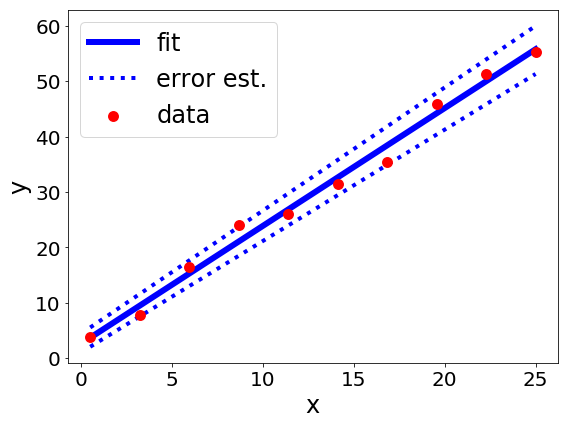

In [9]:
########### PLOT
# first generate points for fitted function
n_fitpts=10
x_fit=np.linspace(np.min(x),np.max(x),n_fitpts)
# this is the best fit
y_fit=intercept+slope*x_fit
# now for fit 5/100 lowest intercept & slope
y_fit_lower_conf=min_intercept_boot+min_slope_boot*x_fit
# now for fit 95/100 intercept & slope
y_fit_upper_conf=max_intercept_boot+max_slope_boot*x_fit
######### Now generate plot
plt.figure(figsize = (8,6) )
# plot data as scatter plot,
plt.scatter(x,y,s=120,c='red',linewidth=0,label='data',zorder=2)
# plot fitted function, zorder = 1 < 2 so line underneath points
plt.plot(x_fit,y_fit,linewidth=6,c='blue', label='fit',zorder=1)
# plot estimates of lower and upper 
plt.plot(x_fit,y_fit_lower_conf,linewidth=4,c='blue',linestyle=':',zorder=1,label='error est.')
plt.plot(x_fit,y_fit_upper_conf,linewidth=4,c='blue',linestyle=':',zorder=1)
plt.xlabel('x',fontsize=24)
plt.ylabel('y',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper left',fontsize=24)
plt.tight_layout()
#	plt.legend(loc='upper right')
#	plt.axhline(color = 'gray', zorder=-1)
# save plot to file
#plt.savefig('tmp.pdf')
# display plot on screen
#plt.show()

The formulas in std_errors() below essentially assume that the best fit slope and intercept have Gaussian probability density
distributions, and then the formulas below estimate the standard deviations of these probability density distributions
NB For rather technical reasons there are various variants in these formulas with n_pts and (n_pts-2)  - the 2 here
is the number of fit parameters (intercept and slope) As these are just ESTIMATES and as n has to be >> 1
to get reliable results, in practice the difference between n_pts and (n_pts-2) is not worth worrying about

In [10]:
# std error formula, as described in most stats textbooks
def std_errors():
    y_error=intercept+slope*x - y
    std_yerr=np.sqrt(np.sum(y_error**2)/(n_pts-2.0))
    mean_x=np.sum(x)/float(n_pts)
    std_error_slope=std_yerr/np.sqrt(np.sum((x-mean_x)**2))
    std_error_intercept=std_yerr*np.sqrt(np.sum(x**2)/(n_pts*np.sum((x-mean_x)**2)))
    return std_yerr,std_error_slope,std_error_intercept


In [11]:
std_yerr,std_error_slope,std_error_intercept=std_errors()
print('standard (rms) error in y values ','%5.2f'%(std_yerr))
print('std error estimate for intercept ','%5.2f'%(std_error_intercept))
print('std error estimate for slope ','%5.2f'%(std_error_slope))
print('best fit value of intercept    ',format(intercept,"5.2f"),'+/-',format(2.0*std_error_intercept,"4.2f"))
print('best fit value of slope    ',format(slope,"5.2f"),'+/-',format(2.0*std_error_slope,"4.2f"))
#
print('compare to known true intercept ',format(real_intercept,"5.2f"))
print('compare to known true slope     ',format(real_slope,"5.2f"))

standard (rms) error in y values   1.89
std error estimate for intercept   1.14
std error estimate for slope   0.08
best fit value of intercept      2.62 +/- 2.29
best fit value of slope      2.13 +/- 0.15
compare to known true intercept   1.30
compare to known true slope       2.20


Note that here the error bars of 2 times the standard errors include the known true values

So far we have looked at the problem:if we ASSUME that the data is a straight line plus noise, what are our estimates for the values of the two parameters, intercept and slope, that define a straight line. This error analysis says essentially NOTHING about whether this assumption that the data really is a straight line, is true or false.

Perhaps the best simple check on the assumption for the functional form we chose for fitting, here a straight line, is to plot the residuals, ie the y values of the data minus the y values from the fit, as a function of x. IF the data really are a straight line plus noise, these residuals should just be random noise, ie no trend to increase or decreases with x. However, if the straight line is not the correct functional form, they a pattern in the residuals may be apparent.


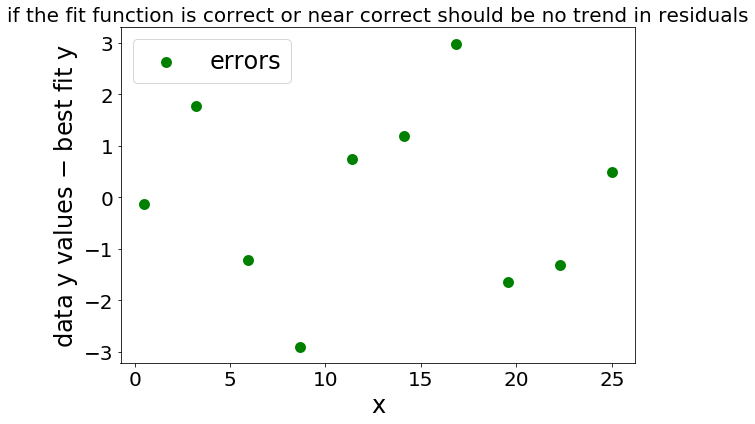

In [12]:
## plot errors to look for trend
######### Now generate plot
plt.figure(figsize = (10,6) )
# plot data as scatter plot,
plt.title('if the fit function is correct or near correct should be no trend in residuals',fontsize=20)
# these are the error or residuals in y values
y_error=intercept+slope*x - y
plt.scatter(x,y_error,s=120,c='green',linewidth=0,label='errors',zorder=2)
plt.xlabel('x',fontsize=24)
plt.ylabel('data y values $-$ best fit y',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper left',fontsize=24)
plt.tight_layout()
plt.show()

Note that these residuals just look like noise, ie no trend - as they should, we know that the data here really is a straight line plus noise.